In [9]:
import pandas as pd
from utils import Options
import pickle as pkl
import numpy as np
from glob import glob
from readresults.readres_mvpa import merge_results, parse_roi_info, exclude_participants, \
    get_subj_avg, fill_in_nvoxels, quick_get_results, group_results
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
import seaborn as sns
from plotting.plot import plot_by_nvoxels, get_tfce_stats
import pingouin as pg
import os
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
results = merge_results(['/project/3018040.05/MVPA_results/results_main_nothresh_1718_m15.csv',
                         '/project/3018040.05/MVPA_results/results_main_nothresh_1937_m15.csv'])
results = exclude_participants(results)
results = parse_roi_info(results)
grouped_res = group_results(results, avg_across=['split', 'view', 'runno', 'trainmodel', 'testmodel',
                                                 'traintask', 'testtask', 'hemi'])

In [34]:
results_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']!='none')]
results_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']!='none')]

In [38]:
voxelavg_1718 = results_1718.groupby(['subject', 'expected']).mean().reset_index()
pg.ttest(voxelavg_1718[voxelavg_1718['expected']==True].distance,
         voxelavg_1718[voxelavg_1718['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.852128,33,two-sided,0.007438,"[0.02, 0.12]",0.501156,5.556,0.809559


stat_fun(H1): min=2.358657 max=3.673130
Running initial clustering
Using 368 thresholds from 0.00 to 3.67 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


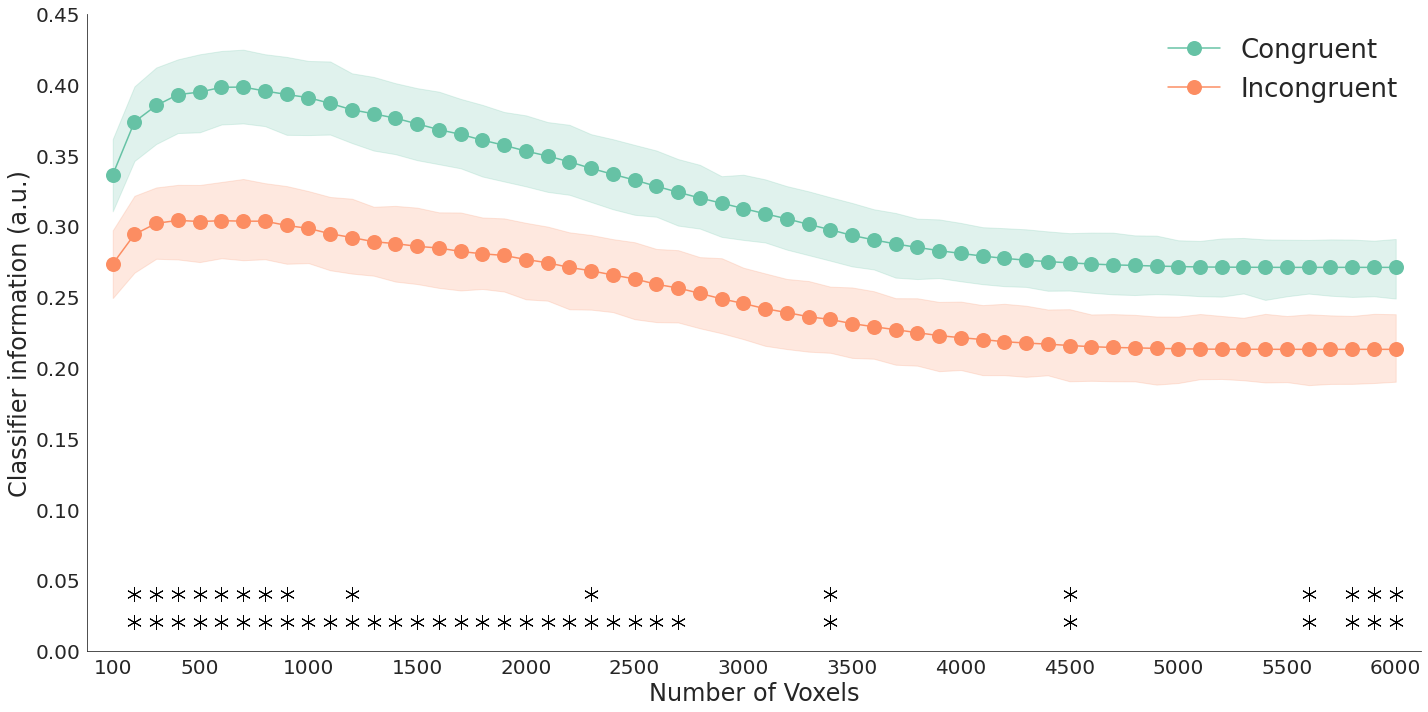

In [35]:
plot_by_nvoxels(results_1718)

stat_fun(H1): min=-0.422969 max=1.816805
Running initial clustering
Using 182 thresholds from 0.00 to 1.81 for TFCE computation (h_power=2.00, e_power=0.50)
Found 60 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


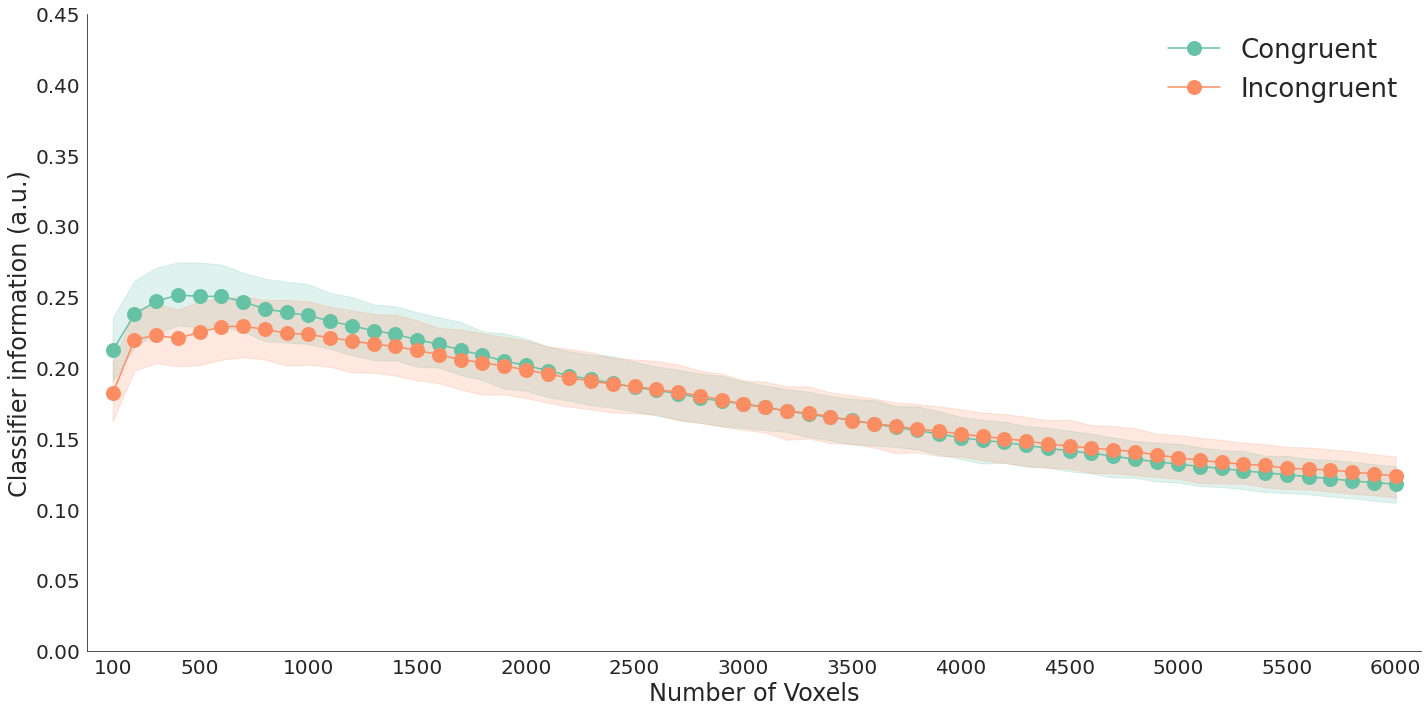

In [39]:
plot_by_nvoxels(results_1937)

In [ ]:
plot_by_nvoxels(results_1718)

In [26]:
fullroi_1718 = grouped_res[(grouped_res['roi']=='ba-17-18')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1718[fullroi_1718['expected']==True].distance,
         fullroi_1718[fullroi_1718['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.111196,33,two-sided,0.042415,"[0.0, 0.1]",0.434467,1.301,0.69116


In [27]:
fullroi_1937 = grouped_res[(grouped_res['roi']=='ba-19-37')&(grouped_res['nvoxels']==6100)]
pg.ttest(fullroi_1937[fullroi_1937['expected']==True].distance,
         fullroi_1937[fullroi_1937['expected']==False].distance,
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.048063,33,two-sided,0.961956,"[-0.03, 0.03]",0.010184,0.184,0.050381


<AxesSubplot:xlabel='nvoxels', ylabel='distance'>

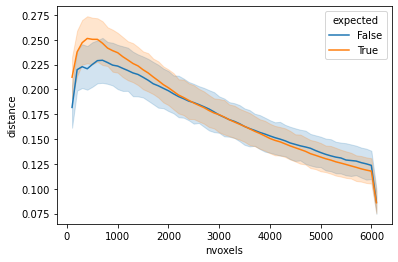

In [22]:
sns.lineplot(data=grouped_res[grouped_res['roi']=='ba-19-37'], 
             x='nvoxels', y='distance', hue='expected', ci=68)

In [ ]:
plot_by_nvoxels(results)

In [ ]:
meanres = results.groupby(['subject', 'expected']).mean().reset_index()

In [ ]:
pg.ttest(meanres[meanres['expected']==True]['distance'],
         meanres[meanres['expected']==False]['distance'], paired=True)

In [ ]:
t_obs, clusters, cluster_pv, H0 = get_tfce_stats(results, measure='distance', n_perms=1000)

In [ ]:
cluster_pv

In [ ]:
t_obs

In [ ]:
EVCdata.distance.min()

In [ ]:
LOCdata.distance.max()

In [ ]:
len(EVCdata)/34/30

In [ ]:
EVCdata.roi.nunique()

In [ ]:
plot_by_nvoxels(results)

In [ ]:
plot_by_nvoxels(EVCdata)

In [ ]:
'ba-17-18' in EVCdata.roi.unique()

In [ ]:
EVCdata.roi

In [ ]:
from plotting.plot import accs_to_diffs

avgdiffs = accs_to_diffs(EVCdata)

In [ ]:
avgdiffs = avgdiffs.groupby(['subject', 'hemi']).mean().reset_index()

In [ ]:
avgdiffs.difference.max()

In [ ]:
avgdiffs.difference.min()

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
maxvoxels = 3000
['100']+[str(x) for x in np.arange(500, maxvoxels+500, 500)]

In [ ]:
EVCdata[EVCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
LOCdata[LOCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
avgres

In [ ]:
results[results['approach']=='CV'].chunk.unique()

In [ ]:
from readresults.readres_mvpa import parse_roi_info

In [ ]:
results_avg = results.groupby(['subject', 'roi']).mean().reset_index()

In [ ]:
results = parse_roi_info(results)

In [ ]:
results = results.drop(['chunk'], axis=1)

In [ ]:
ind_vars = ['subject', 'roi', 'approach', 
            'traindataformat', 'testdataformat', 'traintask',
            'testtask', 'trainmodel', 'testmodel', 
            'hemi', 'contrast', 'nvoxels']
ind_vars = [i for i in ind_vars if i in results.columns and results[i].nunique() > 0]

In [ ]:
results_avg = results.groupby(ind_vars).mean().reset_index()

In [ ]:
results_avg = results_avg.drop(['chunk'], axis=1)

In [ ]:
results_avg.head()

In [ ]:
sns.barplot(data=results_avg, x='roi', y='distance')

In [ ]:
allinfo = 'LO_contr-objscrvsbas_top-1000'.split('_')

In [ ]:
allinfo[1] in ['L', 'R']

In [ ]:
allinfo

In [ ]:
contrindx = 1

In [ ]:
allinfo[contrindx].split('contr-')[1]

In [ ]:
a = [None, None, None]
all(v is None for v in a)

In [ ]:
sns.barplot(data=results, x='roi', y='correct')

In [ ]:
results[results['roi'].isin(['rBA17_18_L', 'rBA17_18_R',
                             'ba-17-18_L', 'ba-17-18_R'])].distance.mean()

In [ ]:
outputs = [0.3, 4.0, 6.9, 2.0, 3.5, 0.1]
targets = [4.7, 3.2, 1.0, 2.9, 3.2, 6.8]
splits = [1, 1, 1, 2, 2, 2]
example_res = pd.DataFrame(
    list(zip(outputs, targets, splits)),
    columns=['output', 'target', 'split'])

In [ ]:
example_res

In [ ]:
x = np.array([3, 4, 5])
np.isin(x, [5])

In [ ]:
example_res = np.nan
isinstance(example_res, float) and pd.isnull(example_res)

In [ ]:
pd.isna(example_res).all()

In [ ]:
outs2 = [0.5, 0.65, 1.2]
splits2 = [3, 3, 3]
example_res_2 = pd.DataFrame(
    list(zip(outs2, splits2)),
    columns=['output', 'split'])

In [ ]:
all_res = pd.concat([example_res, example_res_2])

In [ ]:
all_res

In [ ]:
for s in sorted(example_res.split.unique()):
    thissplitlength = len(example_res[example_res['split']==s])
    example_res.loc[example_res['split']==s, 'sample'] = list(range(thissplitlength))

In [ ]:
groupedres = example_res.groupby('sample').mean().reset_index().drop(['sample', 'split'], axis=1)

In [ ]:
groupedres

In [ ]:
agg_functions = {'output': 'mean', 'target': 'sum'}

#create new DataFrame by combining rows with same id values
res_new = example_res.groupby(example_res['split']).aggregate(
    agg_functions)

In [ ]:
res_new

In [ ]:
with open('/project/3018040.05/MVPA_results/traintest.pkl', 'rb') as f:
    results = pkl.load(f)

In [ ]:
res = results['train-trainm3-test-testm3_ba-17-18_L_betas'][0]
accuracy = res[:, 0]==res[:, 1]
res_df = pd.DataFrame(res, 
                      columns = ['output', 'target', 'distance', 'chunk'])

In [ ]:
res_df['trialno'] = 1

In [ ]:
res_df.to_numpy()

In [ ]:
accuracy.shape

In [ ]:
random = np.random.rand(accuracy.shape[0])

In [ ]:
random

In [ ]:
output = (res[:, 0] == np.unique(res[:, 1])[0]).astype(int)

In [ ]:
output

In [ ]:
np.mean([True, True, False])

In [ ]:
outputs = 

In [ ]:
res_df.distance.dtype

In [ ]:
results['train-trainm3-test-testm3_ba-17-18_L_betas'][0].shape

In [ ]:
opt = Options()

In [ ]:
import configs

In [ ]:
dir(configs)

In [ ]:
configs.mvpa_outdir

In [ ]:
from configs import mvpa_outdir as data_dir

In [ ]:
from six.moves import cPickle as pickle

In [ ]:
data_dir

In [ ]:
mvpa_datadir

In [ ]:
x

In [ ]:
opt.sub = 'sub-001'

In [ ]:
opt.sub

In [ ]:
eventsfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_run-1_events.tsv'
behavfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_beh.tsv'
events = pd.read_csv(eventsfile, sep='\t')
behav = pd.read_csv(behavfile, sep='\t')

In [ ]:
events

In [ ]:
bedscenes = [2, 5, 6, 7, 9, 13, 14, 17, 18, 20]
bedindx = behav.index[behav['Scene'].isin(bedscenes)]
couchindx = behav.index[~behav['Scene'].isin(bedscenes)]

In [ ]:
bedindx

In [ ]:
couchindx